# Simulating The Beer Distribution Game

The [Beer Distribution Game](https://en.wikipedia.org/wiki/Beer_distribution_game) was originally developed in the late 1950s by Jay Forrester at MIT to introduce the concepts of dynamical systems. I first learned about the Beer Game at the turn of the century, through Peter Senge's lovely exposition in "The Fifth Discipline" and I have found the game quite fascinating ever since.

What makes the Beer Game so interesting?

For me the key point is that the game has quite simple rules, yet it still illustrates many aspects of managing a complex business ecosystem. Playing the game with multiple players, either online or using a board version of the game, adds a whole bunch of "soft factors", such as making decisions under (time) pressure and (lack of) communication between players add an extra dynamic.

Here is my list of favorite Beer Game features:

* The Beer Game neatly illustrates the _dynamics of supply chains_, in particular the [bullwhip effect](https://en.wikipedia.org/wiki/Bullwhip_effect).
* In a very tangible way, the game demonstrates how difficult it is to _manage dynamic systems_, even if you think you understand them, along with the frustration that can arise when you don't have control of all variables in the system.
* It is a wonderful illustration of _model-driven scientific thinking_ - reducing a complex reality to a conceptually much simpler model and then using that model to reason about reality.
* The Beer Game is also a great object of study to see how computational modeling can help you to understand complex systems. I've always been a fan of [Raymond Queneau's](https://en.wikipedia.org/wiki/Raymond_Queneau) brilliant [Exercises In Style](https://en.wikipedia.org/wiki/Exercises_in_Style) that retells the same story in 99 different styles – our open source [GitHub repository](https://github.com/transentis/beergame) now illustrates three different ways of building a simulation model of the Beer Game, using System Dynamics XMILE, the System Dynamics DSL and Agent-based modeling.
* I have also found the game to be a useful testbed to see how machine learning techniques such as reinforcement learning can be used to train agents to play the beer game autonomously, as documented in the notebook [Training AI to Play the Beer Game](training_ai_beergame.ipynb).

I've already written about the Beer Game quite extensively, in particular the notebook [Understanding the Beer Game](understanding_the_beergame.ipynb) analyzes playing strategies in detail using a simulation model built using System Dynamics.

That notebook does a good job of explaning the dynamics underlying the Beer Game, but it doesn't actually explain the structure of the stock and flow model itself. This notebook fills that gap.

If you have never played the beergame, you might like to try it before you read this post. You can access the game at [beergame.transentis.com](https://beergame.transentis.com). This version of the beergame was built entirely using the open source [BPTK framework](https://www.transentis.com/business-prototyping-toolkit/en/).

## Reminder: Structure of the Beer Game Supply Chain

The supply chain underlying the Beer Game leads from the brewery that produces the beer, via a distributor and wholesaler to the reseller, who sells beer to his customers, the end consumers.

The sketch below illustrates the supply chain and the flow of information along it:

<div align="center"><img src="images/supply_chain.svg" width="90%"></div>

## Designing a Stock and Flow Model

Whenever you build a simulation model, the first thing you should try to figure out is the top level structure of the model.

We typically refer to the high-level building blocks of a model as _modules_, and each module then contains other modules or - in the case of System Dynamics models – the actual stock and flow models.

The key insight when build a stock and flow model for the Beer Game is that the game is purposely designed to ensure that the brewery, the distributor, the wholesaler and the retailer are actually governed by the same dynamics - with one small exception: the brewery doesn't order beer from a supplier but produces the beer itself. But the beer production takes just as long as it takes to place and fulfill an order in the rest of the supply chain, so the dynamic behaviour is the same.

Thanks to this insight, we can abstract this common behaviour into a single structure, which we can then either reuse or replicate when building the actual simulation model.

Do we need any other modules? Yes, we do:

* The whole point of having a simulation model is that we want to monitor the performance of each of the players and the supply chain itself. Because we aren't just looking at individual players but also at overall performance it makes sense to extract the monitoring of the supply chain into a separate part of the model.

* To ensure all parts of our supply chain use the same decision policies and settings for e.g the price of beer and the time it takes to order or produce beer, we extract the settings into a separate module.

This leaves us with the model structure shown in the diagram below.

<div align="center"><img src="images/model_structure.svg" width="90%" ></div>

Now that we know the overall model structure, let's take a look at the stocks and flows we need to model the supply chain modules.

Each module in the supply chain has a supplier and a customer. Let's pretend to be a player in the supply chain and let's walk through the supply chain management process from that perspective:

1. First of all, your customer calls you and makes an order. You note this down in a list called `Orders received`.
2. You then check your `Inventory` to see whether you can fulfill the customers request.
3. You give your customer whatever you can and note that down in your `Deliveries made` list.
4. You make an order to your supplier, to cover the beer your customer ordered. To keep track of the orders you make you keep a list called `Open orders`.

That defines the stocks that you need to keep track of what is going on in your part of the supply chain.

Note that the beer itself can be in one of three states: it is either on order (ie. still with your supplier or on the way), it can be in your inventory, or you have made the delivery and it is on the way to your customer (or has already been received by the customer).

We can model this as a chain of stocks and flows, as shown in the diagram below. 

<div align="center"><img src="images/supply_chain_module.svg" width="80%"></div>

The diagram also shows two indicators that we can use to measure the performance of our supply chain: the *backorder* and the *surplus*.

The _backorder_ is simply the difference between orders received and deliveries made. In the best case the backorder is equal to 0, i.e. you can always fulfill your customers wishes:

`Backorder = Orders_received - Deliveries_made`

The _surplus_ is the difference between the intenvory and the backorder. The surplus measures how much beer you have to cover incoming customer requests. It should always be a positive number, but not too big, to keep inventory costs down.

`Surplus = Inventory - Backorder`

Now that we have the stocks and the indicators, we can take a look at the flows and associated rates.

Let's start with the _incoming orders_. This is equal to the _incoming order rate_, which itself is just equal to the order being sent by your customer:

`Incoming_Orders = Incoming_Order_Rate = Customer.Sending_Orders`

And now let's walk through the beer supply chain:

The number of outgoing orders is equal to the orders you make.

`Outgoing_Orders = Order_Decision`

Of course the key question in the entire beergame is how you make that order decision - because it is so important we'll defer the detailed discussion of the order decision to the next section.

The incoming deliveries depends on the incoming delivery rate, and this in turn is equal to the outgoing deliveries beeing sent by your supplier, delayed by the amount of time it takes for the goods to reach you.

In our game this delay is equal to one week, in the model the delay is governed by the delivery delay setting in the policy settings. This leads to the following equation:

`Incoming_Deliveries = Incoming_Delivery_Rate = Delay(Supplier.outgoing_deliveries,Policy_Settings.Delivery_Delay,100.0)`

The only flow remaing is the _outgoing deliveries_, which is equal to the `outgoing_delivery_rate`. Here the policy is quite simple: we always want to deliver as much as we can, i.e. the sum of the backorder and the currently incoming order. But we can't delivery more than what is currenlty the inventory and what is just arriving. This leads to the following equations:

`Outgoing_Deliveries= Outgoing_Delivery_Rate = Min(Backorder+Incoming_orders,Inventory+Incoming_Deliveries)`


### The Order Decision

Now let's come back to the order decision. In our model we have implemented two order decisions, a "naive" one which ignores backorders and the supply line and a "sophisticated" one which takes them into account. The different effects of this decision are discussed at length in the notebook [Understanding the Beergame](understanding_the_beergame.ipynb)  - so here I will just give you a brief summary.

In the naive order decision, you essentially order everything the customer is ordering right now, plus the entire backorder, plus the difference between your current inventory and your target inventory:

`Naive_Order_Decision =  Backorder + Incoming_Order_Rate + Policy_Settings.Target_Inventory - Inventory`

A more sophisticated order decision ignores the backorder, but includes the supply line (i.e. the open orders). It also avoids sending shocks up the supply line and adjust inventory slowly. This leads to the following equation:

`Sophisticated_Order_Decision = Incoming_Order_Rate + (Policy_Settings.Target_Inventory - Inventory + Target_Supply_Line - Open_Orders)/Policy_Settings.Inventory_Adjustment_Time`

The target supply line needs to account both for the expected order and for the delivery delays:

`Target_Supply_Line = Incoming_Order_Rate *(Policy_Settings.Delivery_Delay + Policy_Settings.Order_Delay)`

The diagram sums up the factors that are relevant for the order decision:

<div align="center"><img src="images/sophisticated_order_decision.svg" width="90%"></div>

I've created a little dashboard so that you can test the effect of the order decision on the supply chain.

In [1]:
from BPTK_Py import bptk
bptk = bptk()

In [2]:
%run src/dashboard/beergame_dashboard_sd_dsl.ipy

## Building the Model Using the SD DSL

Now that we have designed the stock and flow model, we can build it using the SD DSL. We'd like the code to be as modular as the model itself, i.e. we'd like to keep the code for each module in a separate Python class and would also like to reuse as much of the code as possible.

You can find the source code in the _src/sd_dsl_ folder, the following diagram provides an overview of the class structure.

<div align="center"><img src="images/class_diagram.svg" width="90%"></div>

To achieve this, we use the Module class which is part of the BPTK framework.```

We then define a subclass [SupplyChainModule](src/sd_dsl/supplyChainModule.py) which implements the stock and flow model illustrated above. Because the BPTK framework does all the heavy lifting regarding simulation, the `SupplyChainModule` is really just a list of equations. At runtime, this class will be instantiated four times, once each for the brewery, the wholesaler, the distributor and the retailer.

```Python
class SupplyChainModule(Module):
    def __init__(self, model, name):
        super().__init__(model, name)
        
        # Exports - initialize all variables here that are used by other modules
        self.sending_orders = self.flow("sending_orders") 
        self.outgoing_deliveries = self.flow("outgoing_deliveries")
        
        # Exports for subclasses
        self.incoming_delivery_rate = self.converter("incoming_delivery_rate")
        
        # further exports
        #  ...
        
    def initialize(self, supplier, customer, policy_settings):
        # define and initialize all remaining equations
        
        # ....
        
        ### Sophisticated Order Decision as an example

        sophisticated_order_decision.equation = 1.0*sd.round((sd.max(incoming_order_rate+(policy_settings.target_inventory-self.inventory + policy_settings.include_supply_line_on*(target_supply_line-open_orders))/policy_settings.inventory_adjustment_time,0.0)),0)
```

Because the brewery is at the end of the supply chain, it acts as its own supplier, i.e. we need to "override" the equation for the incoming delivery rate. To achive this, we create a subclass of `SupplyChainModule` called [Brewery](src/sd_dsl/brewery.py). This class just contains the one equation which redefines the `incoming_deliver_rate`.

```Python

class Brewery(SupplyChainModule):
    def __init__(self, model,name):
        super().__init__(model, name)

    def initialize(self, supplier, customer, policy_settings):
        super().initialize(supplier, customer, policy_settings)
        self.incoming_delivery_rate.equation = sd.delay(self.model,self.sending_orders,policy_settings.delivery_delay, 100.0)
```


We also need a class for the [Consumer](src/sd_dsl/consumer.py) - this class just consists of one equation that represents the consumers orders.

```Python
class Consumer(Module):

    def __init__(self, model, name):
        super().__init__(model,name)

        # Exports
        self.sending_orders = self.converter("sending_orders")

    def initialize(self, policy_settings):
        # Equations
        self.sending_orders.equation = 100.0 + sd.If(policy_settings.steady_state_on == 0.0,1.0,0.0)*sd.step(policy_settings.rise_in_consumer_order,1.0)
```

All children of `Module` distinguish between the usual `init` constructor and an `initialize` method. The `init` constructor is used to instantiate all elements of a module that will be referenced by other modules (i.e. these are the model elements that are exported by a module). The initialize method is then used to initialize the equations set up by the init method along with the equations that are internal to a module.

Now that we have all of the modules, we can put them together in a model. For this we create a [Beergame](src/sd_dsl/beergame.py) class that subclasses the `Model` class of the BPTK framework.


At runtime, the `Beergame`class instantiates each of the modules and puts them together in the right order.

It is important to understand that all these classes are just _builder_ classes that are used to encode the equations for the System Dynamics model dynamically. The module objects are just instantiated briefly during initialization of the `Beergame` object. After initialization of the `Beergame` object, the builder classes are no longer needed and go out of scope.

The equations themselves are encoded into Python functions by the BPTK framework and are stored in the `equations` dictionary of the `Beergame` object. They are used to calculate the simulation results at runtime.

The [PolicySettings](src/sd_dsl/policySettings.py) and [PerformanceControlling](src/sd_dsl/performanceControlling.py) classes are very simple - the settings class just contains a list of constants, the performance controlling a few simple stocks and flows that accumulate the supply chain cost over the course of the simulation.

Now that we have all the classes, we can instantiate the beergame as follows:

In [3]:
from src.sd_dsl.beergame import Beergame
beergame = Beergame()

Here is a subset of the equations in the beergame, nicely set up using the `<module>.<element>` syntax, thanks to the `Module` class.

In [4]:
list(beergame.equations.keys())

['consumer.sending_orders',
 'retailer.sending_orders',
 'retailer.outgoing_deliveries',
 'retailer.inventory',
 'retailer.backorder',
 'retailer.incoming_delivery_rate',
 'wholesaler.sending_orders',
 'wholesaler.outgoing_deliveries',
 'wholesaler.inventory',
 'wholesaler.backorder',
 'wholesaler.incoming_delivery_rate',
 'distributor.sending_orders',
 'distributor.outgoing_deliveries',
 'distributor.inventory',
 'distributor.backorder',
 'distributor.incoming_delivery_rate',
 'brewery.sending_orders',
 'brewery.outgoing_deliveries',
 'brewery.inventory',
 'brewery.backorder',
 'brewery.incoming_delivery_rate',
 'policy_settings.target_inventory',
 'policy_settings.target_retailer_cost',
 'policy_settings.target_supply_chain_cost',
 'policy_settings.target_surplus',
 'policy_settings.inventory_adjustment_time',
 'policy_settings.include_supply_line_on',
 'policy_settings.steady_state_on',
 'policy_settings.sophisticated_order_decision_on',
 'policy_settings.order_delay',
 'policy_sett

And here is a comparison of consumer order behaviour vs. retailer order behaviour (using the naive order decision policy).

In [5]:
[(beergame.equations["consumer.sending_orders"](i),beergame.equations["retailer.order_decision"](i)) for i in range(1,24)]

[(100.0, 100.0),
 (400.0, 400.0),
 (400.0, 700.0),
 (400.0, 1000.0),
 (400.0, 1000.0),
 (400.0, 1200.0),
 (400.0, 1200.0),
 (400.0, 1400.0),
 (400.0, 1400.0),
 (400.0, 1600.0),
 (400.0, 1600.0),
 (400.0, 400.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0),
 (400.0, 0.0)]

So the model is implemented and functional, now let's test it it in depth using the BPTK frameworks `bptk` class and the scenario mechanism.

## Testing The Model

All scenarios are kept in the [scenario file](scenarios/beergame_sd_dsl.json). This file is read automatically by the framework when the `bptk` class is instantiated.

All scenarios start with the following base settings:

```json
  "base_constants":{
            "policy_settings.steady_state_on":1.0,
            "policy_settings.sophisticated_order_decision_on":0.0,
            "policy_settings.include_supply_line_on":0.0,
            "policy_settings.inventory_adjustment_time":1.0
        }
```

### Steady State Behaviour

The `steady_state_scenario`is equivalent to the base settings, hence the scenario is empty:
```json

 "steady_state":{
    
        }
```


As expected, in the steady state both orders and inventory are stable for all parts of the supply chain.

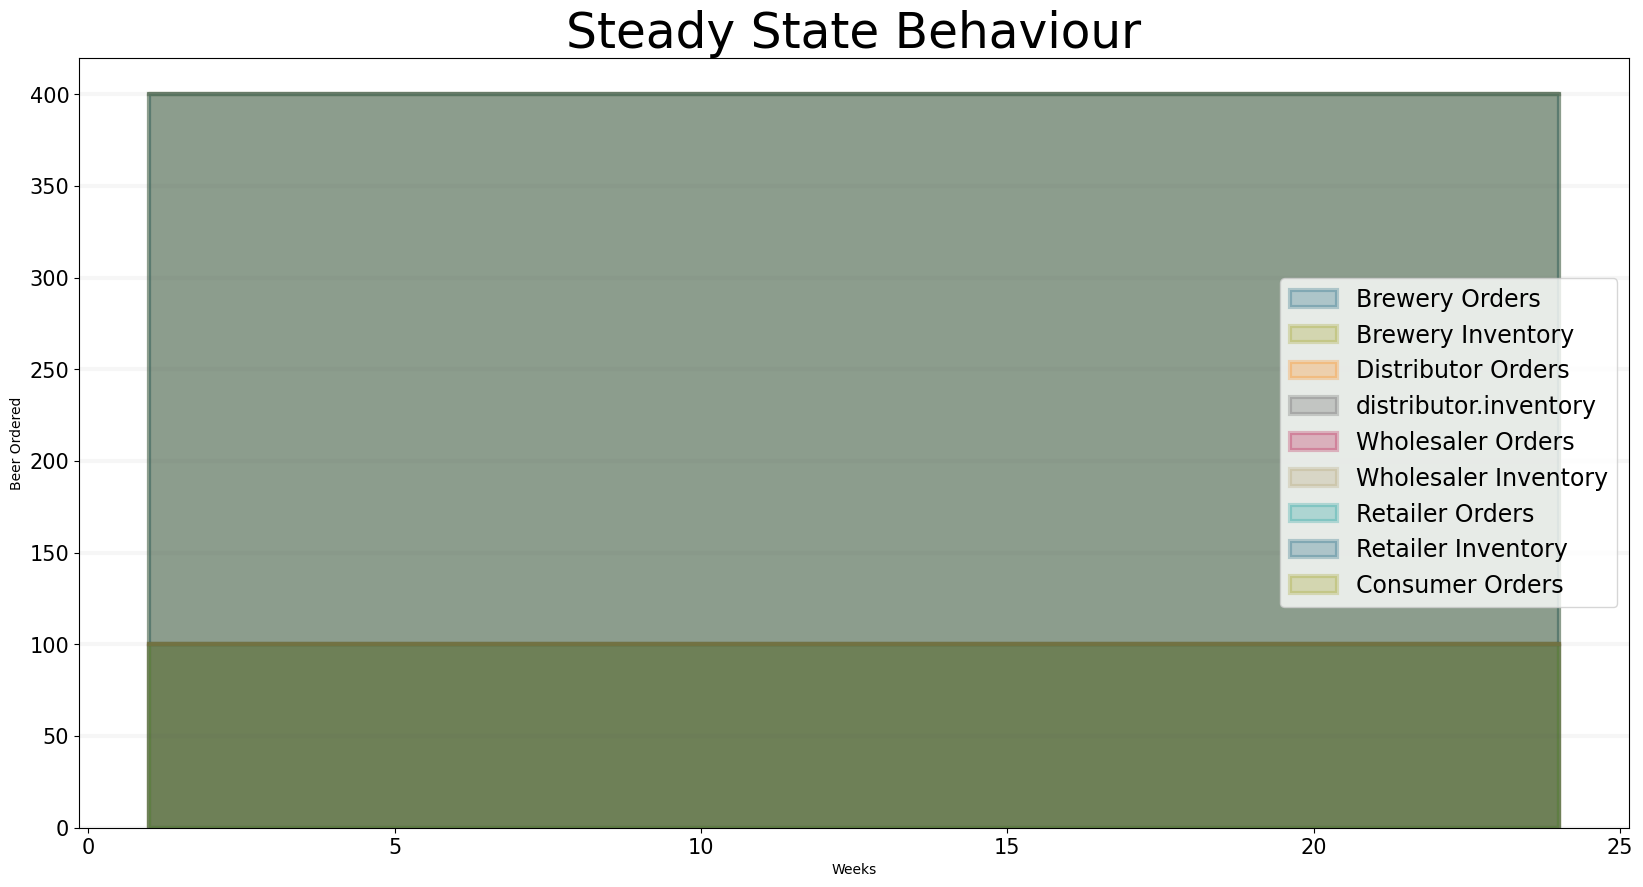

In [6]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["steady_state"],
    title="Steady State Behaviour",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","brewery.inventory","distributor.sending_orders","distributor.inventory","wholesaler.sending_orders","wholesaler.inventory","retailer.sending_orders","retailer.inventory","consumer.sending_orders"],
    series_names={
        "brewery.sending_orders" : "Brewery Orders",
        "brewery.inventory" : "Brewery Inventory",
        "distributor.sending_orders" : "Distributor Orders",
        "distrubutor.inventory" : "Distributor Inventory",
        "wholesaler.sending_orders": "Wholesaler Orders",
        "wholesaler.inventory": "Wholesaler Inventory",
        "retailer.sending_orders": "Retailer Orders",
        "retailer.inventory": "Retailer Inventory",
        "consumer.sending_orders": "Consumer Orders"
    }
)

### Typical Playing Behaviour ("Naive Order Decision")

Typical playing behaviour follows the naive order strategy, as discussed above. We get this by turning the steady state behaviour off:

```json

   "typical":{
           "constants":{
                "policy_settings.steady_state_on":0.0
           }

        }

```



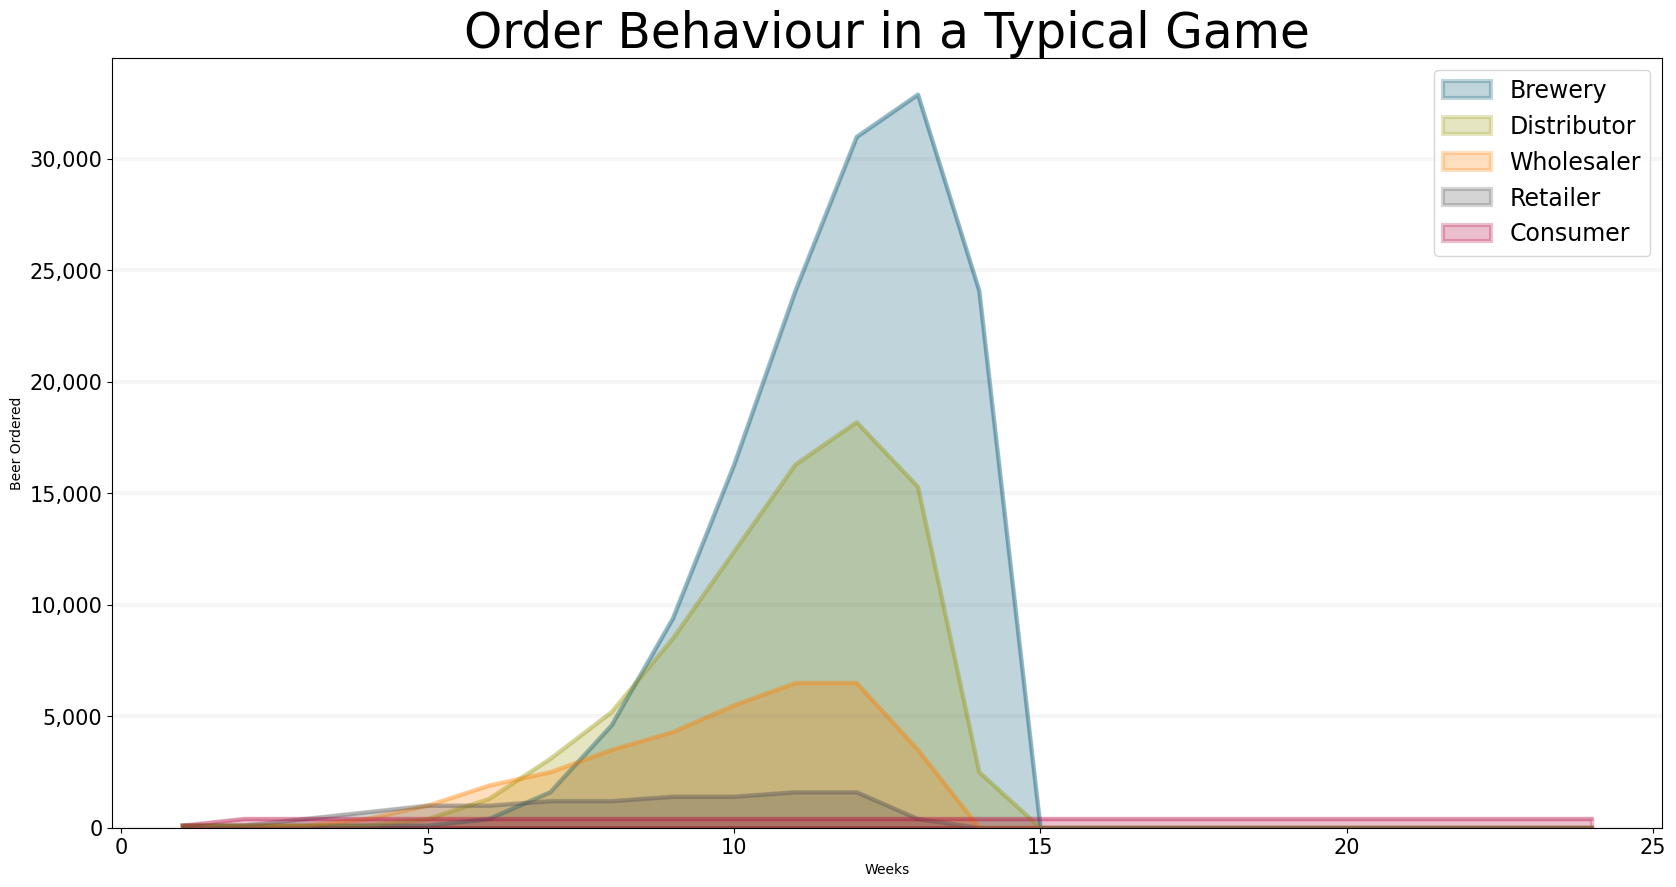

In [7]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["typical"],
    title="Order Behaviour in a Typical Game",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders", "consumer.sending_orders"],
    series_names={
        "sd_dsl_beergame_typical_brewery.sending_orders" : "Brewery",
        "sd_dsl_beergame_typical_distributor.sending_orders" : "Distributor",
        "sd_dsl_beergame_typical_wholesaler.sending_orders": "Wholesaler",
        "sd_dsl_beergame_typical_retailer.sending_orders": "Retailer",
        "sd_dsl_beergame_typical_consumer.sending_orders": "Consumer"
    }
)

### Advanced Playing Behaviour ("Sophisticated Order Decision")

The sophisticated ordering strategy is achieved with the following settings:

```json
  "inventory_adjustment_time_8":{
            "constants":{
                "policy_settings.steady_state_on":0.0
                "policy_settings.sophisticated_order_decision_on":1.0,
                "policy_settings.include_supply_line_on":1.0,
                "policy_settings.inventory_adjustment_time":8.0
            }
        }
```


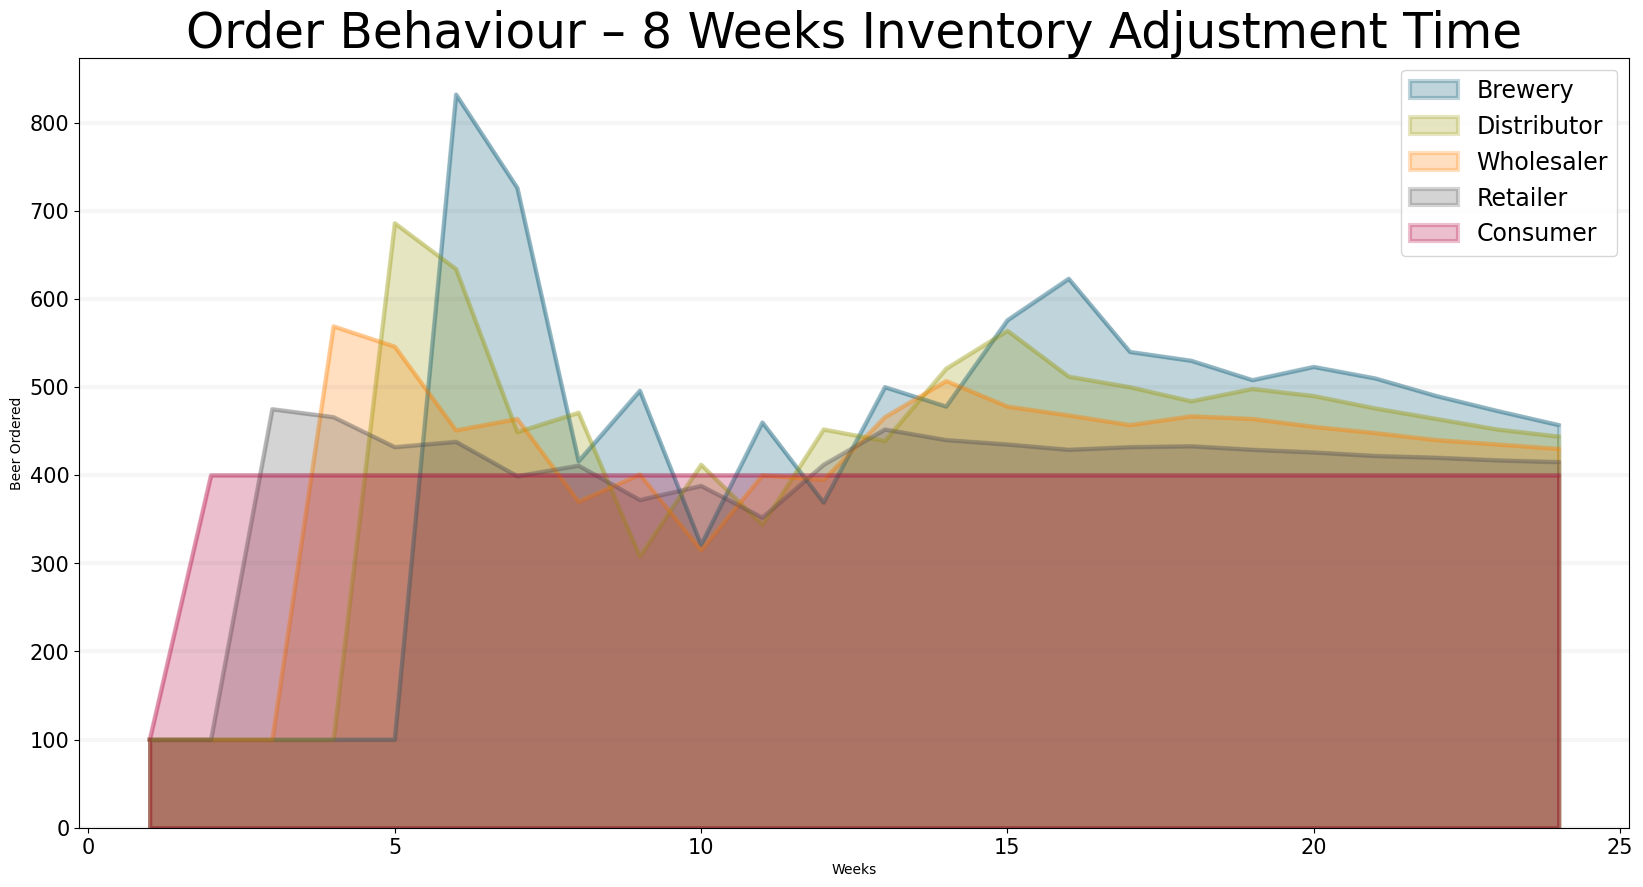

In [8]:
bptk.plot_scenarios(
    scenario_managers=["sd_dsl_beergame"],
    kind="area",
    scenarios=["inventory_adjustment_time_8"],
    title="Order Behaviour – 8 Weeks Inventory Adjustment Time",
    x_label="Weeks",
    y_label="Beer Ordered",
    equations=["brewery.sending_orders","distributor.sending_orders","wholesaler.sending_orders","retailer.sending_orders", "consumer.sending_orders"],
    series_names={
        "sd_dsl_beergame_inventory_adjustment_time_8_brewery.sending_orders" : "Brewery",
        "sd_dsl_beergame_inventory_adjustment_time_8_distributor.sending_orders" : "Distributor",
        "sd_dsl_beergame_inventory_adjustment_time_8_wholesaler.sending_orders": "Wholesaler",
        "sd_dsl_beergame_inventory_adjustment_time_8_retailer.sending_orders": "Retailer",
        "sd_dsl_beergame_inventory_adjustment_time_8_consumer.sending_orders": "Consumer"
    }
)